loss = f(w1, w2, ... , wn, b), 
 needs to reduce this loss to predict the class or value accurately.
this is where gradient descent helps by changing the weights after every epoch to reduce the loss until minimized.
.backward() does this whole process. this is what we'll try to replicate.

Thus we need to store the value of the object and it's history, also the operation applied on the previous inputs to get the current variable or the loss function we can say.

In [1]:
import math
import random
import torch

In [2]:
# x.grad ie dL/dx how is L changing wrt x

In [12]:
class Value:
    
    def __init__(self, data, _children = (), _op = '', label = ''): # _atribute means this attribute/function is used internally in the class
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None 
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        # cannot add int to Value, so:
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+') # creating a value object after this operation.
        
        # need += as one node may be connected to 2 other nodes, if only = 1 node will set the grad of the child, we need to accumulate both of them
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __radd__(self, other): # other + self
        return self + other
    
    # cannot do 2*a so rmull
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):
        return self*other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers now"
        out = Value(self.data ** other, (self,),  f'**{other}')
        
        def _backward():
            self.grad += (other * (self.data **(other - 1))) * out.grad
        out._backward = _backward
        
        return out
        
    def __neg__(self):
        return self*-1 # multiply so no need to define explicitly ie self.data * -1 so _backward also mantained

    
    def __truediv__(self, other): #self/other
        return (self * (other**-1))
    
    def __rtruediv__(self, other): #other/self
        return (other * (self**-1))
    
    def __sub__(self, other): 
        other = other if isinstance(other, Value) else Value(other)
        return self + (-other) # add and negation, so _backward also mantained
    
    def __rsub__(self, other): # other - self
        return other + (-self)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
# so whenever last operation will be done to get the final node of the graph, one of these function will be called, hence _backward will also be implemented and then will be stored in out._backward
    
    # backward func will only be called by the root node.
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [13]:
# visualizing the connections and expressions
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # lR -> left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid , label = "{%s | data %.4f  | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation create an op node for it
            dot.node(name = str(id(n)) + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        # connect n1 to op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

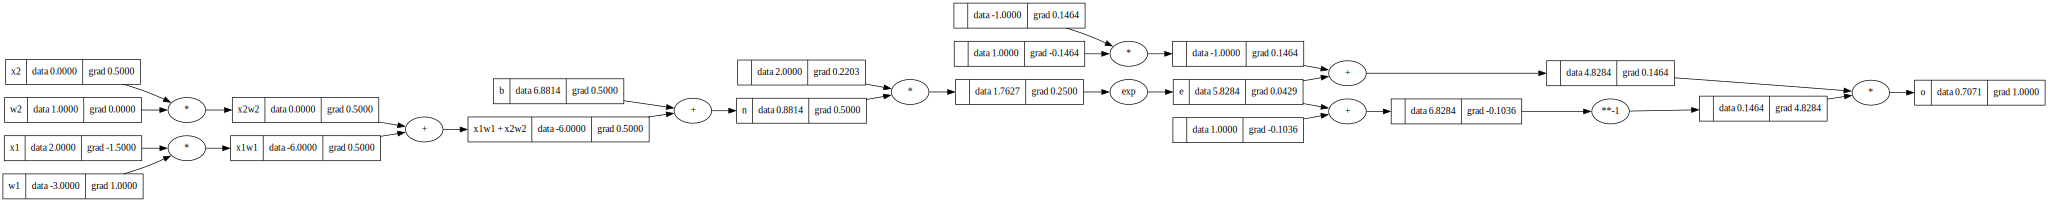

In [14]:
# implementing a simple neuron

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp(); e.label = 'e'
o = (e - 1) / (e + 1)

o.label = 'o';
o.backward()
draw_dot(o)

In [15]:
# doing the same thing in pytorch

In [16]:
x1 = torch.Tensor([2.0]).double();  x1.requires_grad = True
x2 = torch.Tensor([0.0]).double();  x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double();  w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();  w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double();  b.requires_grad = True
# pytorch assumes leaf nodes don't require gradients, so need to initialize to true

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('-------')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
-------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


1 neuron is taking i/p vector dimension, getting weight vector for that and then finally performing dot product and returning the value.Therefore 1 neuron returning 1 value after performing operation ---> wx + b


1 layer is taking i/p vector dimension and total no. of neurons in that layer and then generating that no. of neurons and performing above operation.


mlp class is taking i/p vector dimension 'x', list of total no. of neurons in a layer, thus len(list) will give total layers, its __call__ function takes 'x' ie a element of that list , which gives neurons in a layer, feeds i-1th element to ith layer ie dimension of the vector that gets dot producted with w as each neuron gives 1 value.

In [17]:
class Neuron:
    
    def __init__(self, nin): # nin is the no. of i/p to a neuron or no. of features fed to the neuron.
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)] # list of values
        self.b = Value(random.uniform(-1, 1))
        
    def __call__(self, x):
        # w*x + b here w*x is a dot product
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) # value + data or data + value
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer: 
    
    def __init__(self, nin, nout): # nout is the no. of neurons in the layer
        self.neurons = [Neuron(nin) for _ in range(nout)] # list of neurons created, now need to feed i/p to these.
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        # return [p for neuron in self.neurons for p in neuron.parameters()]
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
            return params
    
class MLP:
    
    def __init__(self, nin, nouts): # nouts here are the list of nouts or the size of all the layers that we want in the mlp. So len(nouts) will be the total layers and nout[i] will give the totla neurons in that layer i. 
        sz = [nin] + nouts # as no. of inputs to a neuron will be total no. of neurons in previous layer + it's i/p
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        

 # sz[i] is the size of a neuron or the i/p size 


In [18]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.8099933515872684)

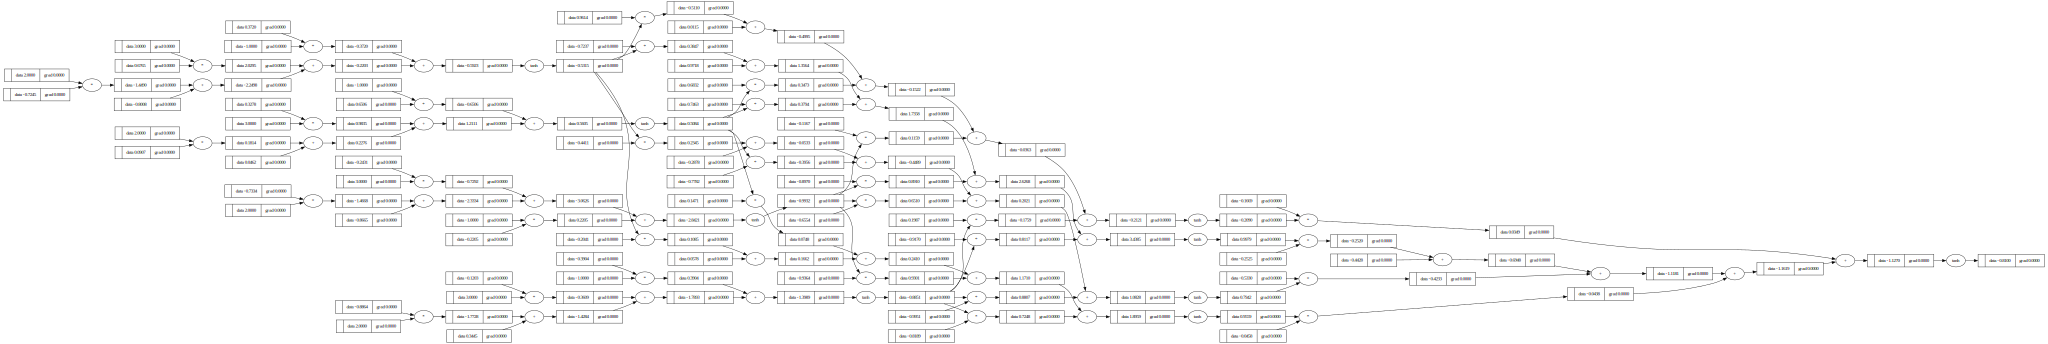

In [19]:
draw_dot(n(x))

In [265]:
# list = [4, 4, 0]
# nin = [2]
# [nin] + list

In [20]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] 
# desired targets
# want to make a binary classifier

In [21]:
n = MLP(3, [4, 4, 1])
for k in range(50):
    
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))
    
    #backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    #update
    for p in n.parameters():
        p.data += -0.05 * p.grad
    
    print(k, loss.data)

0 4.500838805650966
1 1.6051414489138334
2 0.9338241448799437
3 0.6544084275650126
4 0.4974127410117473
5 0.3951034189648577
6 0.32340773586348326
7 0.2708295176594095
8 0.2309665248534066
9 0.1999408587345852
10 0.17526787213340164
11 0.15528783857691336
12 0.13885480552065957
13 0.12515560938666917
14 0.11359964611093301
15 0.10374921483313271
16 0.09527412905221938
17 0.08792135439790269
18 0.08149422827443913
19 0.07583794687162573
20 0.0708292443975466
21 0.06636893299988536
22 0.06237643013625123
23 0.05878568938097241
24 0.055542137099505486
25 0.052600339933699024
26 0.049922209960200845
27 0.04747561004232855
28 0.045233260271484915
29 0.0431718732161751
30 0.04127146468143636
31 0.03951480027783806
32 0.03788694794397422
33 0.03637491376833438
34 0.03496734377610852
35 0.03365427831160761
36 0.0324269486278514
37 0.031277607553956144
38 0.030199387836143714
39 0.029186183075223124
40 0.028232547211179113
41 0.02733360930672312
42 0.026485001010144435
43 0.025682794573702226
4

In [22]:
ypred

[Value(data=0.9267152950423466),
 Value(data=-0.9577112434732667),
 Value(data=-0.9030043832858369),
 Value(data=0.9285825641041617)]

In [23]:
len(n.parameters())

14